### Reinforcement learning model (DDQN with CNN):
This code creates a reinforcement learning model (using a double DQN with a convolutional neural network as the policy and target networks) for the classification of vibration data into the three classes: healthy, inner ring fault or outer ring fault. Several experiments are made to train and test the model. At the end test results are shown with several visualizations to interpret the performance of the model.

In [1]:
# libraries
import numpy as np

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.optimizers import Adam

from sklearn.metrics import (confusion_matrix, accuracy_score, classification_report, roc_curve, auc)

import collections

import gym
import random

import matplotlib.pyplot as plt
import plotly.figure_factory as ff

import os


In [3]:
# load the dataset, returns train and test X and y elements
def load_dataset():
	"""
	This function loads the train and test processed datasets priorly saved.
	
	Output:
	- trainX, testX: numpy arrays of shape (n_samples, 512, 2)
		512 frequency data points for each sample and the rotational speed for each sample
	- trainy, testy: numpy arrays of shape (n_samples, 3)
		one hot encoding of y for the 3 classes (healthy, inside ring damage, outside ring damage)
	"""

	# load all data
	with open('data/processed/trainX.npy', 'rb') as f:
		trainX = np.load(f)
	with open('data/processed/trainy.npy', 'rb') as f:
		trainy = np.load(f)
	with open('data/processed/testX.npy', 'rb') as f:
		testX = np.load(f)
	with open('data/processed/testy.npy', 'rb') as f:
		testy = np.load(f)
	
	print("train: ",trainX.shape, trainy.shape, "\ntest: ", testX.shape, testy.shape,"\n")
	
	return trainX, trainy, testX, testy

In [3]:
# define model
def get_model(trainX, trainy, learning_rate):
    """
    This function is used to get a CNN model.

    Input:
    - trainX, trainy: the training dataset values and targets
    - learning_rate: the learning rate for the adam optimizer

    Output:
    - model: the keras CNN model built
    """

    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    
    model = Sequential()
    model.add(Conv1D(filters=3, kernel_size=5, activation='relu',input_shape=(n_timesteps,n_features)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=12, kernel_size=2, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['accuracy'])
    
    return model

In [ ]:
# Define a named tuple to represent a single experience, which
# contains the state, action, reward, new state, and done values
Experience = collections.namedtuple('Experience', 
           field_names=['state', 'action', 'reward', 
           'new_state', 'done'])

class ExperiencePool:
    """
    A class to represent a buffer of experiences for reinforcement learning.
    """

    def __init__(self, capacity):
        """
        Initialize the experience pool with a maximum capacity.

        Input:
        - capacity (int): The maximum number of experiences to store in the pool.
        """
        # Initialize a deque to store experiences with maximum capacity
        self.buffer = collections.deque(maxlen=capacity)
        # Initialize a counter to keep track of the number of experiences added to the pool
        self.pool_counter = 0

    def __len__(self):
        """
        Return the current number of experiences in the pool.
        """
        return len(self.buffer)

    def append(self, experience):
        """
        Add a new experience to the pool.

        Input:
        - experience (Experience): A named tuple representing a single experience.
        """
        # Append the experience to the deque
        self.buffer.append(experience)
        # Increment the experience counter
        self.pool_counter += 1

    def sample(self, batch_size):
        """
        Sample a batch of experiences from the pool.

        Input:
        - batch_size (int): The number of experiences to sample.

        Output:
        - A tuple containing the sampled states, actions, rewards, new states, and done values.
        """
        # Sample indices from the range [0, len(buffer)) without replacement
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        # Use the indices to retrieve the corresponding experiences from the deque
        states, actions, rewards, next_states, dones = zip(*[self.buffer[idx] for idx in indices])
        # Return the sampled experiences as numpy arrays
        return np.array(states), np.array(actions), \
                np.array(rewards, dtype=np.float32), \
                np.array(next_states), \
                np.array(dones, dtype=np.uint8)


In [ ]:
class DDQNAgent(object):
    """
    A class representing a Double Deep Q-Network agent, which interacts with an environment
    using Q-learning and experience replay.
    """
    def __init__(self, learning_rate, discount_factor, action_space,
                 trainX, trainy, batch_size,
                 epsilon_decay, epsilon_min, epsilon_0,
                 mem_size, replace_target):
        """
        Initializes the DDQNAgent object.

        Input:
        - learning_rate: the learning rate for the optimizer
        - discount_factor: the discount factor for future rewards
        - action_space: a list of possible actions the agent can take
        - trainX: the input training data for the neural network
        - trainy: the output training data for the neural network
        - batch_size: the batch size used in training the neural network
        - epsilon_decay: the decay factor for the exploration rate
        - epsilon_min: the minimum exploration rate
        - epsilon_0: the initial exploration rate
        - mem_size: the size of the experience replay buffer
        - replace_target: how often the target network should be updated
        """
        self.action_space = action_space
        self.n_actions = 3
        self.gamma = discount_factor

        self.epsilon_min = epsilon_min
        self.epsilon_0 = epsilon_0
        self.epsilon_decay = epsilon_decay
        self.epsilon = self.epsilon_min + (self.epsilon_0 - self.epsilon_min) * np.exp(-self.epsilon_decay)
        self.reward_count = 0

        self.batch_size = batch_size
        self.replace_target = replace_target
        self.pool = ExperiencePool(mem_size)

        self.q_policy = get_model(trainX, trainy, learning_rate)
        self.q_target = get_model(trainX, trainy, learning_rate)
        self.update_network_parameters()

    def update_epsilon(self):
        """
        Updates the exploration rate of the agent based on the episode count.
        """
        self.epsilon = self.epsilon_min + (self.epsilon_0 - self.epsilon_min) * np.exp(-self.epsilon_decay * self.episode_count)

    def reset_pool(self, mem_size):
        """
        Resets the experience replay pool with a maximum size.

        Input:
        - mem_size: the maximum size of the experience replay pool
        """
        self.pool = ExperiencePool(mem_size)

    def set_episode_count(self, episode_count):
        """
        Sets the episode count for the agent.

        Input:
        - episode_count: the new episode count
        """
        self.episode_count = episode_count

    def add_experience(self, experience):
        """
        Adds a new experience to the experience replay pool.

        Input:
        - experience: a tuple containing the state, action, reward, new state and done flag of the experience
        """
        self.pool.append(experience)

    def choose_action(self, state):
        """
        Chooses an action for the agent based on the current state.

        Input:
        - state: the current state of the agent

        Output:
        - the chosen action for the agent
        """
        state = state[np.newaxis, :]
        rand = np.random.random()
        # exploration/exploitation tradeoff
        if rand < self.epsilon:
            action = np.random.choice(self.action_space)
        else:
            actions = self.q_policy.predict(state, verbose=0)
            action = np.argmax(actions)

        return action
    
    def learn(self):
        """
        Performs the learning step by sampling a batch of experiences from the experience pool,
        and updating the policy network to better approximate the optimal Q-values.

        Output:
        - history.history['accuracy']: list of values for accuracy throughout the training process
        - history.history['loss']: list of values for loss throughout the training process
        """
        # Check if enough experiences are present in the pool to sample a batch
        if self.pool.pool_counter >= self.batch_size:
            # Sample a batch of experiences from the experience pool
            states, actions, rewards, new_states, dones = self.pool.sample(self.batch_size)

            # Predict the Q-values for the next states using the target network
            q_next_target = self.q_target.predict(new_states, verbose=0)
            # Predict the Q-values for the next states using the policy network
            q_policy_next = self.q_policy.predict(new_states, verbose=0)
            # Predict the Q-values for the current states using the policy network
            q_policy_pred = self.q_policy.predict(states, verbose=0)

            # Select the actions with maximum Q-value for the next states
            max_actions = np.argmax(q_policy_next, axis=1)

            # Compute the target Q-values for the current states using the Bellman equation
            y_j = q_policy_pred
            batch_index = np.arange(self.batch_size, dtype=np.int32)
            not_dones = (0==dones).astype(int)
            y_j[batch_index, actions] = rewards + \
                    self.gamma*q_next_target[batch_index, max_actions.astype(int)]*not_dones

            # Train the policy network on the sampled batch
            history = self.q_policy.fit(states, y_j, verbose=2, batch_size=self.batch_size, epochs=1)

            # Update the target network periodically
            if self.episode_count % self.replace_target == 0:
                self.update_network_parameters()

            return history.history['accuracy'], history.history['loss']

        # Return 0 accuracy and loss if not enough experiences are present in the pool
        return 0, 0
    
    def update_network_parameters(self):
        """
        Updates the weights of the target network to match the policy network.
        """
        self.q_target.set_weights(self.q_policy.get_weights())



In [ ]:
class PowerPlantEnv(gym.Env):
    """
    Custom gym environment for classifying rotating machinery faults in a power plant.
    """
    def __init__(self, dataset):
        """
        Initializes the environment class.

        Input:
        - dataset: input features and labels
        """
        super().__init__()
        self.action_space = gym.spaces.Discrete(3) # Three possible classes (healthy, inner ring fault, outer ring fault)
        self.x, self.y = dataset

    def step(self, action):
        """
        Executes one step in the environment. Receives an action from the agent, calculates the corresponding reward, 
        returns the new observation, the reward, a boolean flag indicating whether the episode has terminated, and any 
        additional information.

        Input:
        - action (int): an integer indicating the selected action (0 for healthy, 1 for inner ring fault, 
                        2 for outer ring fault).

        Output:
        - obs (numpy.ndarray): the new observation (i.e., input features for the selected example)
        - reward (float): the reward obtained from the action (1 for a correct classification, -1 for an incorrect 
                          classification).
        - done (bool): a boolean flag indicating whether the episode has terminated (which is always False)
        - info (dict): a dictionary containing any additional information (not used in this environment)
        """
        # if action taken corresponds to the expected action, positivie reward
        if action == self.expected_action:
            reward = 1
        else:
            reward = -1
            
        obs = self._next_obs()

        return obs, reward, False, {}

    def _next_obs(self):
        """
        Returns the input features for a randomly selected example from the dataset. Also sets the expected action
        based on the label of the selected example.

        Output:
        - obs (numpy.ndarray): the input features for the selected example.
        """
        next_obs_idx = random.randint(0, len(self.x) - 1)
        self.expected_action = np.argmax(self.y[next_obs_idx])
        obs = self.x[next_obs_idx]

        return obs


#### Training:

The following code initializes the environment, sets hyperparameters, and trains a Double Deep Q-Network (DDQN) agent to classify rotating machinery faults. The training data is loaded, and a PowerPlantEnv environment is created for the agent to interact with. The action space consists of three classes, representing healthy, outer ring fault, and inner ring fault. The agent trains for a specified number of episodes, with each episode consisting of a set number of game rounds. The agent selects an action using an epsilon-greedy policy and learns from its experiences stored in an experience replay buffer. The agent updates its parameters using a DDQN algorithm and periodically updates its target network to prevent overfitting. The agent's cumulative reward, accuracy, and loss are recorded for each episode. The best model is saved and used to predict the fault type of test data.

Several experiments have been performed by changing the hyperparameters, with the best result achieved with the following:
* E = 900 # training episode number
* M = 300 # experience pool capacity
* R = 64 # replay size
* T = 64 # game rounds in one episode
* C = 100 # copy period: training steps to update periodicity of target network
* discount_factor = 0.7 # gamma
* learning_rate = 0.001 # alpha
* epsilon_0 = 0.4  # exploration probability at start
* epsilon_min = 0.001  # minimum exploration probability
* epsilon_decay = 0.3  # exponential decay rate for exploration prob

In [7]:
# Initialization:

# environment
trainX, trainy, testX, testy = load_dataset() # load dataset (x = state, y = action)

env = PowerPlantEnv(dataset=(trainX, trainy))
action_space = [0,1,2] # action space: {0: healthy, 1: OR fault, 2: IR fault}

E = 900 # training episode number
M = 300 # experience pool capacity
R = 64 # replay size
T = 64 # game rounds in one episode
C = 100 # copy period: training steps to update periodicity of target network

discount_factor = 0.9 # gamma
learning_rate = 0.001 # alpha

# epsilon-greedy:
# tradeoff between exploration and exploitation
epsilon_0 = 0.4  # exploration probability at start
epsilon_min = 0.001  # minimum exploration probability
epsilon_decay = 0.3  # exponential decay rate for exploration prob

cum_reward_episode = []
acc_episode = []
loss_episode = []
best_acc = []
best_weights = []

ddqn_agent = DDQNAgent(learning_rate=learning_rate, discount_factor=discount_factor, \
                                action_space=action_space, \
                                trainX=trainX, trainy=trainy, batch_size=R, \
                                epsilon_0=epsilon_0, epsilon_decay=epsilon_decay, \
                                epsilon_min=epsilon_min, mem_size=M, replace_target=C)

for e in range(1,E+1): # training episode
    env = PowerPlantEnv(dataset=(trainX, trainy)) # reset environment
    ddqn_agent.reset_pool(M) # reset experience pool
    ddqn_agent.set_episode_count(e) # set the counter with the number of episodes
    cum_reward = 0
    print("\n>> Episode: ",e,"/",E)
    observation = env._next_obs()
    ddqn_agent.update_epsilon()
    for t in range(1,T+1): # game round
        action = ddqn_agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        done = (t==T)
        cum_reward += reward
        exp = Experience(observation, action, reward, observation_, int(done))
        ddqn_agent.add_experience(exp)
        observation = observation_
        acc, loss = ddqn_agent.learn()
    if acc > best_acc: # save weights if accuracy improves
        best_acc = acc
        best_weights = ddqn_agent.q_policy.get_weights()
    cum_reward_episode.append(cum_reward)
    acc_episode.append(acc)
    loss_episode.append(loss)
    print("Cummulative reward: ",cum_reward)

# save best model
last_weights = ddqn_agent.q_policy.get_weights()
ddqn_model = ddqn_agent.q_policy
ddqn_model.set_weights(best_weights)
models_dir = 'models/'
existing_models = [filename for filename in os.listdir(models_dir) if filename.startswith('ddqn_model')]
num_model = len(existing_models)+1
filename = f'models/ddqn_model_{num_model}.h5'
ddqn_model.save(filename)

(49209, 512, 2) (49209, 3) (10545, 512, 2) (10545, 3)

>> Episode:  1 / 900
1/1 - 1s - loss: 0.3457 - accuracy: 0.2969 - 519ms/epoch - 519ms/step
Cummulative reward:  -22

>> Episode:  2 / 900
1/1 - 0s - loss: 0.3483 - accuracy: 0.4062 - 11ms/epoch - 11ms/step
Cummulative reward:  -26

>> Episode:  3 / 900
1/1 - 0s - loss: 0.3984 - accuracy: 0.3281 - 12ms/epoch - 12ms/step
Cummulative reward:  -28

>> Episode:  4 / 900
1/1 - 0s - loss: 0.3612 - accuracy: 0.3281 - 11ms/epoch - 11ms/step
Cummulative reward:  -26

>> Episode:  5 / 900
1/1 - 0s - loss: 0.3498 - accuracy: 0.4688 - 10ms/epoch - 10ms/step
Cummulative reward:  -12

>> Episode:  6 / 900
1/1 - 0s - loss: 0.3549 - accuracy: 0.3281 - 10ms/epoch - 10ms/step
Cummulative reward:  -22

>> Episode:  7 / 900
1/1 - 0s - loss: 0.3556 - accuracy: 0.4375 - 11ms/epoch - 11ms/step
Cummulative reward:  -12

>> Episode:  8 / 900
1/1 - 0s - loss: 0.3431 - accuracy: 0.4688 - 10ms/epoch - 10ms/step
Cummulative reward:  -6

>> Episode:  9 / 900
1/1

#### Testing (best experiment):

Analysis of results for the best model achieved.

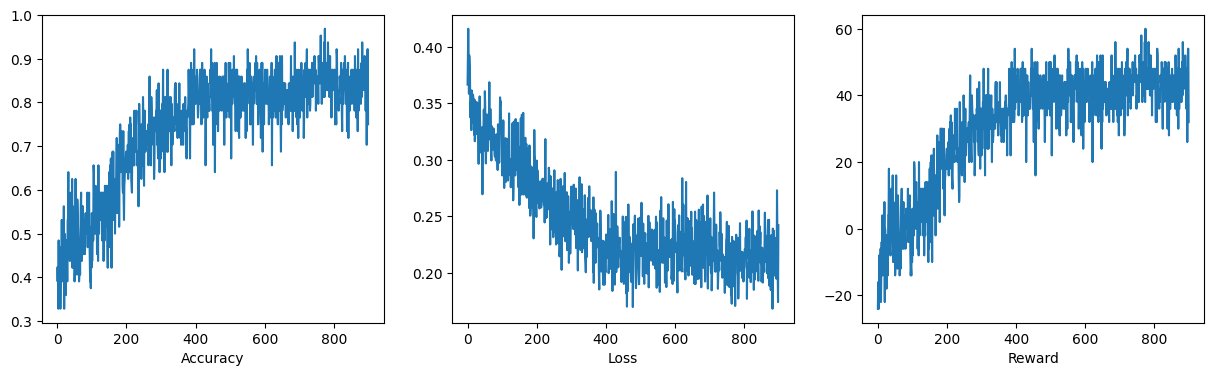

In [8]:
"""
EXPERIMENT 14: experiment with the best results

- E = 900 # training episode number
- M = 300 # experience pool capacity
- R = 64 # replay size
- T = 64 # game rounds in one episode
- C = 100 # copy period: training steps to update periodicity of target network
- discount_factor = 0.7 # gamma
- learning_rate = 0.001 # alpha
- epsilon_0 = 0.4  # exploration probability at start
- epsilon_min = 0.001  # minimum exploration probability
- epsilon_decay = 0.3  # exponential decay rate for exploration prob

Run the following code to load the model: ddqn_model = keras.models.load_model('models/ddqn_model_14.h5')
"""

# Plotd to show how accuracy, loss and cummulative reward change throughout the training process
# x-axis shows the number of epochs that have passed
# y-axis shows the accuracy, loss and cummulative reward values achieved

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].plot(acc_episode)
axs[0].set(xlabel='Accuracy')

axs[1].plot(loss_episode)
axs[1].set(xlabel='Loss')

axs[2].plot(cum_reward_episode)
axs[2].set(xlabel='Reward')

plt.show()

In [6]:
# Run prediction using the test data and evaluate accuracy score

pred_test = ddqn_model.predict(testX)

test_acc = accuracy_score(np.argmax(testy,axis=1), np.argmax(pred_test,axis=1))
print('Test accuracy: ',test_acc)

330/330 [==============================] - 2s 4ms/step
Test accuracy:  0.8480796586059743


In [7]:
# print a classification report to analyze different metrics in addition to accuracy

print(classification_report(np.argmax(testy,axis=1), np.argmax(pred_test,axis=1), target_names=['Healthy', 'OR fault', 'IR fault'],digits=4))

              precision    recall  f1-score   support

     Healthy     0.8500    0.9347    0.8903      3552
    OR fault     0.8471    0.8156    0.8310      3600
    IR fault     0.8468    0.7919    0.8185      3393

    accuracy                         0.8481     10545
   macro avg     0.8480    0.8474    0.8466     10545
weighted avg     0.8480    0.8481    0.8470     10545



In [9]:
# Construct a visualization for the confusion matrix
z_test = confusion_matrix(np.argmax(testy,axis=1), np.argmax(pred_test,axis=1))

# reformat the matrix
z_test[[0,2],:] = z_test[[2,0],:]
x = ['Healthy', 'OR fault', 'IR fault']
y = ['IR fault', 'OR fault', 'Healthy']

def format_text(z):
    """
    This function receives the confusion matrix values and formats the text
    to display in the matrix with the value and percentage of total data.
    """
    return f'{z}<br>({z / np.sum(z_test) * 100:.1f}%)'

z_text = np.vectorize(format_text)(z_test)

heatmap = ff.create_annotated_heatmap(z_test, x=x, y=y, annotation_text=z_text, colorscale='cividis')
heatmap.update_layout(title_text='DDQN Model',height=350,width=500,
                      xaxis_title="Predicted Label",yaxis_title="True Label")
heatmap.show()

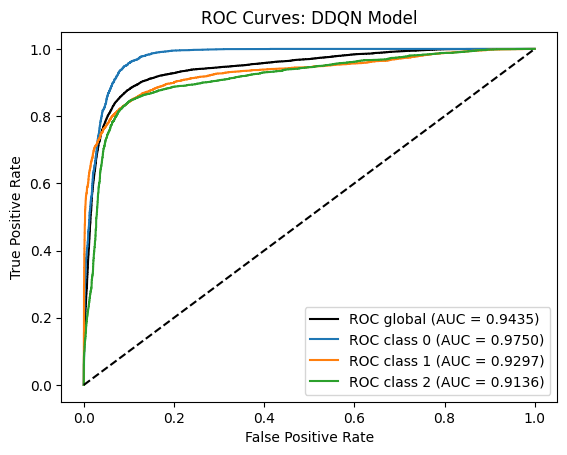

In [7]:
# Obtain ROC curve and AUC values for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(testy[:, i], pred_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Get global ROC curve
fpr["micro"], tpr["micro"], _ = roc_curve(testy.ravel(), pred_test.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Graph to show the global ROC curve and the ROC curves for each class
plt.figure()
plt.plot(fpr["micro"], tpr["micro"], label="ROC global (AUC = {:.4f})".format(roc_auc["micro"]), color="black")
for i in range(3):
    plt.plot(fpr[i], tpr[i], label="ROC class {} (AUC = {:.4f})".format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves: DDQN Model")
plt.legend()
plt.show()

#### Testing (other experiments):

The following code shows the results of some of the other experiments which got worse results than experiment 14.

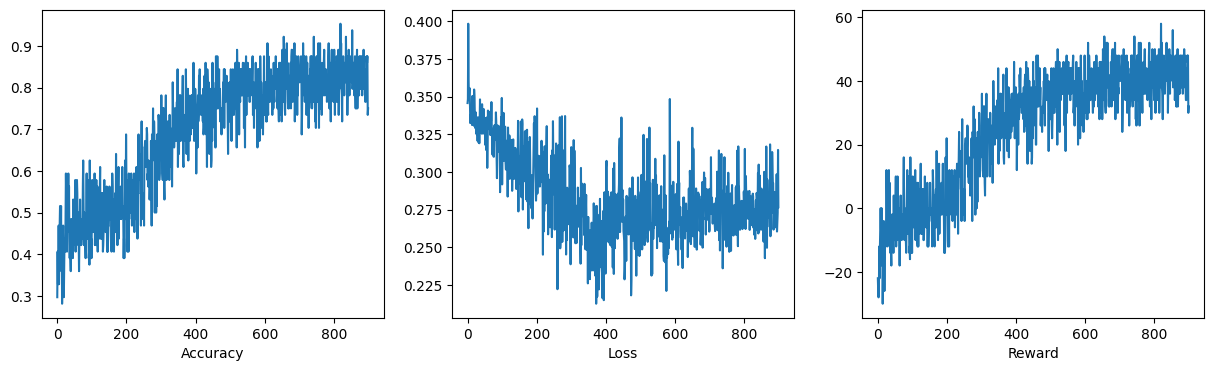

In [8]:
"""
EXPERIMENT 15:

- E = 900 # training episode number
- M = 300 # experience pool capacity
- R = 64 # replay size
- T = 64 # game rounds in one episode
- C = 100 # copy period: training steps to update periodicity of target network
- discount_factor = 0.9 # gamma
- learning_rate = 0.001 # alpha
- epsilon_0 = 0.4  # exploration probability at start
- epsilon_min = 0.001  # minimum exploration probability
- epsilon_decay = 0.3  # exponential decay rate for exploration prob
"""

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].plot(acc_episode)
axs[0].set(xlabel='Accuracy')

axs[1].plot(loss_episode)
axs[1].set(xlabel='Loss')

axs[2].plot(cum_reward_episode)
axs[2].set(xlabel='Reward')

plt.show()

In [9]:
# Run prediction using the test data and evaluate accuracy score
# ddqn_15
pred_test = ddqn_model.predict(testX)

test_acc = accuracy_score(np.argmax(testy,axis=1), np.argmax(pred_test,axis=1))
print('Test accuracy: ',test_acc)

330/330 [==============================] - 10s 29ms/step
Test accuracy:  0.8253200568990042


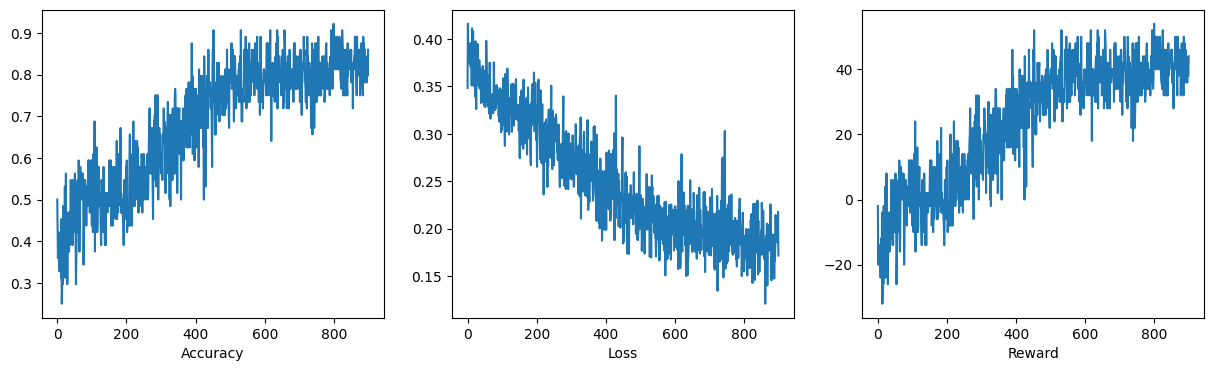

In [8]:
"""
EXPERIMENT 13:

- E = 900 # training episode number
- M = 300 # experience pool capacity
- R = 64 # replay size
- T = 64 # game rounds in one episode
- C = 100 # copy period: training steps to update periodicity of target network
- discount_factor = 0.5 # gamma
- learning_rate = 0.001 # alpha
- epsilon_0 = 0.4  # exploration probability at start
- epsilon_min = 0.001  # minimum exploration probability
- epsilon_decay = 0.3  # exponential decay rate for exploration prob
"""

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].plot(acc_episode)
axs[0].set(xlabel='Accuracy')

axs[1].plot(loss_episode)
axs[1].set(xlabel='Loss')

axs[2].plot(cum_reward_episode)
axs[2].set(xlabel='Reward')

plt.show()

In [9]:
# Run prediction using the test data and evaluate accuracy score
# ddqn_13
pred_test = ddqn_model.predict(testX)

test_acc = accuracy_score(np.argmax(testy,axis=1), np.argmax(pred_test,axis=1))
print('Test accuracy: ',test_acc)

330/330 [==============================] - 8s 24ms/step
Test accuracy:  0.8298719772403983


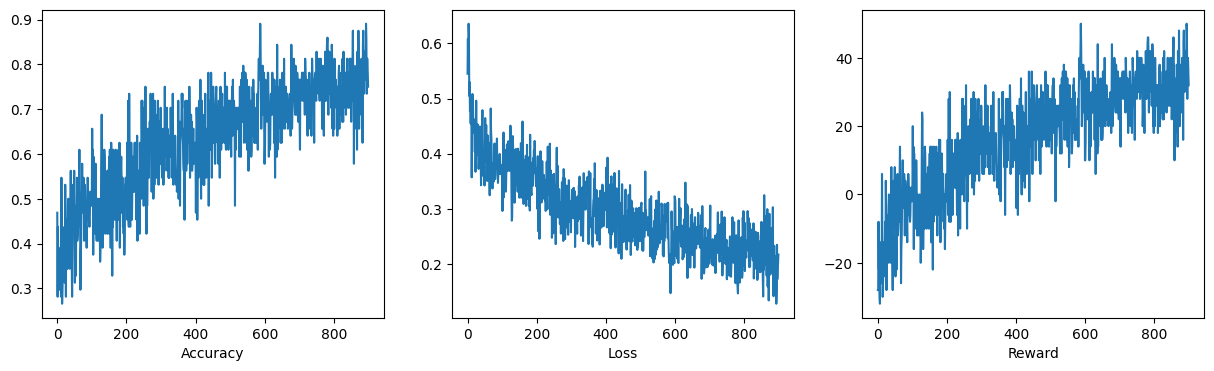

In [8]:
"""
EXPERIMENT 12:

- E = 900 # training episode number
- M = 300 # experience pool capacity
- R = 64 # replay size
- T = 64 # game rounds in one episode
- C = 50 # copy period: training steps to update periodicity of target network
- discount_factor = 0.001 # gamma
- learning_rate = 0.001 # alpha
- epsilon_0 = 0.4  # exploration probability at start
- epsilon_min = 0.001  # minimum exploration probability
- epsilon_decay = 0.3  # exponential decay rate for exploration prob
"""

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].plot(acc_episode)
axs[0].set(xlabel='Accuracy')

axs[1].plot(loss_episode)
axs[1].set(xlabel='Loss')

axs[2].plot(cum_reward_episode)
axs[2].set(xlabel='Reward')

plt.show()

In [9]:
# Run prediction using the test data and evaluate accuracy score
# ddqn_12
pred_test = ddqn_model.predict(testX)

test_acc = accuracy_score(np.argmax(testy,axis=1), np.argmax(pred_test,axis=1))
print('Test accuracy: ',test_acc)

330/330 [==============================] - 8s 25ms/step
Test accuracy:  0.7135135135135136


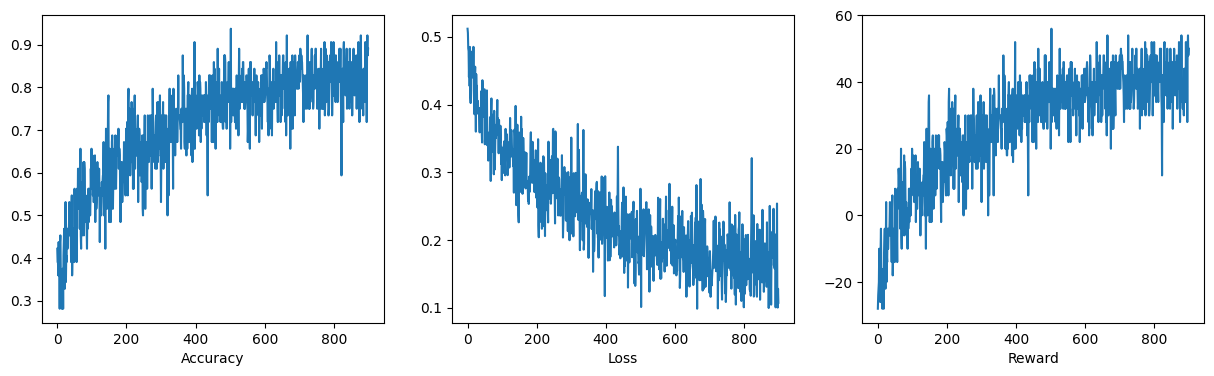

In [9]:
"""
EXPERIMENT 11:

- E = 900 # training episode number
- M = 300 # experience pool capacity
- R = 64 # replay size
- T = 64 # game rounds in one episode
- C = 100 # copy period: training steps to update periodicity of target network
- discount_factor = 0.01 # gamma
- learning_rate = 0.001 # alpha
- epsilon_0 = 0.4  # exploration probability at start
- epsilon_min = 0.001  # minimum exploration probability
- epsilon_decay = 0.3  # exponential decay rate for exploration prob
"""

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].plot(acc_episode)
axs[0].set(xlabel='Accuracy')

axs[1].plot(loss_episode)
axs[1].set(xlabel='Loss')

axs[2].plot(cum_reward_episode)
axs[2].set(xlabel='Reward')

plt.show()

In [10]:
# Run prediction using the test data and evaluate accuracy score
# ddqn_11
pred_test = ddqn_model.predict(testX)

test_acc = accuracy_score(np.argmax(testy,axis=1), np.argmax(pred_test,axis=1))
print('Test accuracy: ',test_acc)

330/330 [==============================] - 8s 23ms/step
Test accuracy:  0.7890943575154101


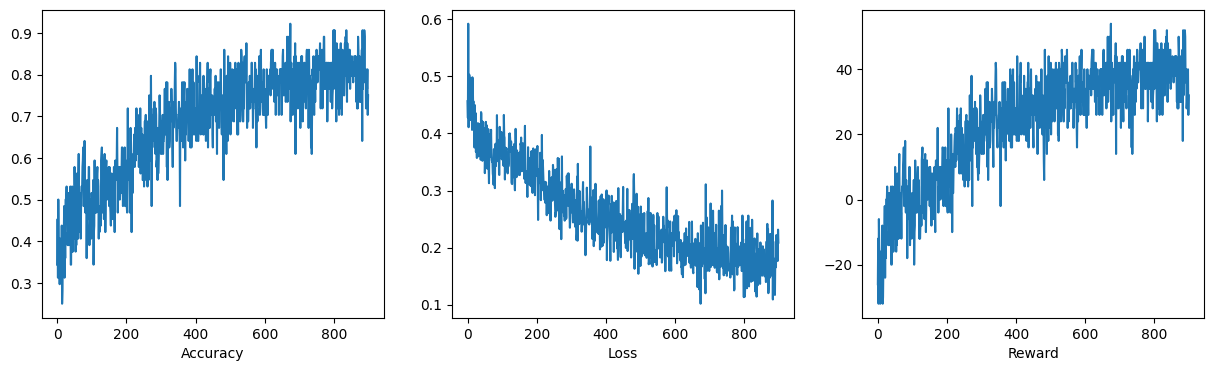

In [8]:
"""
EXPERIMENT 10:

- E = 900 # training episode number
- M = 300 # experience pool capacity
- R = 64 # replay size
- T = 64 # game rounds in one episode
- C = 10 # copy period: training steps to update periodicity of target network
- discount_factor = 0.05 # gamma
- learning_rate = 0.001 # alpha
- epsilon_0 = 0.4  # exploration probability at start
- epsilon_min = 0.001  # minimum exploration probability
- epsilon_decay = 0.3  # exponential decay rate for exploration prob
"""

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].plot(acc_episode)
axs[0].set(xlabel='Accuracy')

axs[1].plot(loss_episode)
axs[1].set(xlabel='Loss')

axs[2].plot(cum_reward_episode)
axs[2].set(xlabel='Reward')

plt.show()

In [11]:
# Run prediction using the test data and evaluate accuracy score
# ddqn_10
pred_test = ddqn_model.predict(testX)

test_acc = accuracy_score(np.argmax(testy,axis=1), np.argmax(pred_test,axis=1))
print('Test accuracy: ',test_acc)

330/330 [==============================] - 12s 36ms/step
Test accuracy:  0.7838786154575629


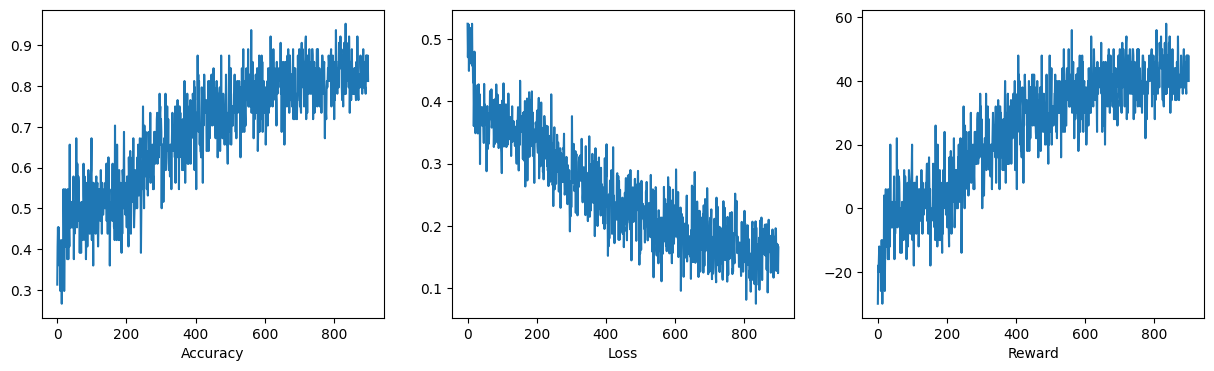

In [8]:
"""
EXPERIMENT 9:

- E = 900 # training episode number
- M = 300 # experience pool capacity
- R = 64 # replay size
- T = 64 # game rounds in one episode
- C = 10 # copy period: training steps to update periodicity of target network
- discount_factor = 0.01 # gamma
- learning_rate = 0.001 # alpha
- epsilon_0 = 0.4  # exploration probability at start
- epsilon_min = 0.001  # minimum exploration probability
- epsilon_decay = 0.3  # exponential decay rate for exploration prob
"""

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].plot(acc_episode)
axs[0].set(xlabel='Accuracy')

axs[1].plot(loss_episode)
axs[1].set(xlabel='Loss')

axs[2].plot(cum_reward_episode)
axs[2].set(xlabel='Reward')

plt.show()

In [11]:
# Run prediction using the test data and evaluate accuracy score
# ddqn_9
pred_test = ddqn_model.predict(testX)

test_acc = accuracy_score(np.argmax(testy,axis=1), np.argmax(pred_test,axis=1))
print('Test accuracy: ',test_acc)

330/330 [==============================] - 2s 6ms/step
Test accuracy:  0.8355618776671409
